To whoever may be reading this:

This notebook documents my journey through Chapter 3: Classification of the O'Reilly book "Hands On Machine Learning with Scikit Learn and TensorFlow.  In it, I mess around with the MNIST dataset and develop a couple different classifiers.

First cell- import modules, customize matplotlib, set up function to save plot images

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Because the old fetch_mldata function is deprecated, we have to use fetch_openml.  However, the MNIST dataset is not sorted when we retrieve it from fetch_openml, hence we create a new function:

In [4]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

Let's fetch some data!

In [6]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

/Users/grifflehman/opt/anaconda3/envs/snowflake/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [7]:
mnist.data.shape

(70000, 784)

In [8]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

Pick a random digit so we can plot and see what it looks like:

Saving figure some_digit_plot


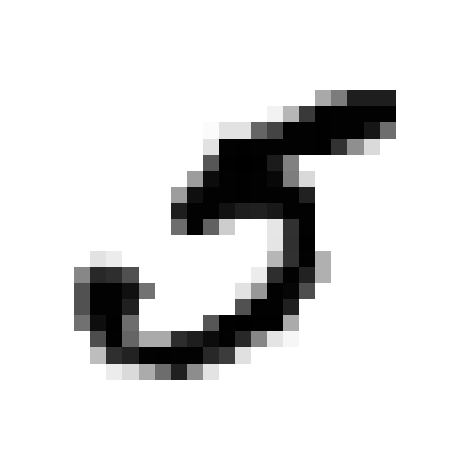

In [10]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

Functions to plot either a singular digit or many instances:

In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [12]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


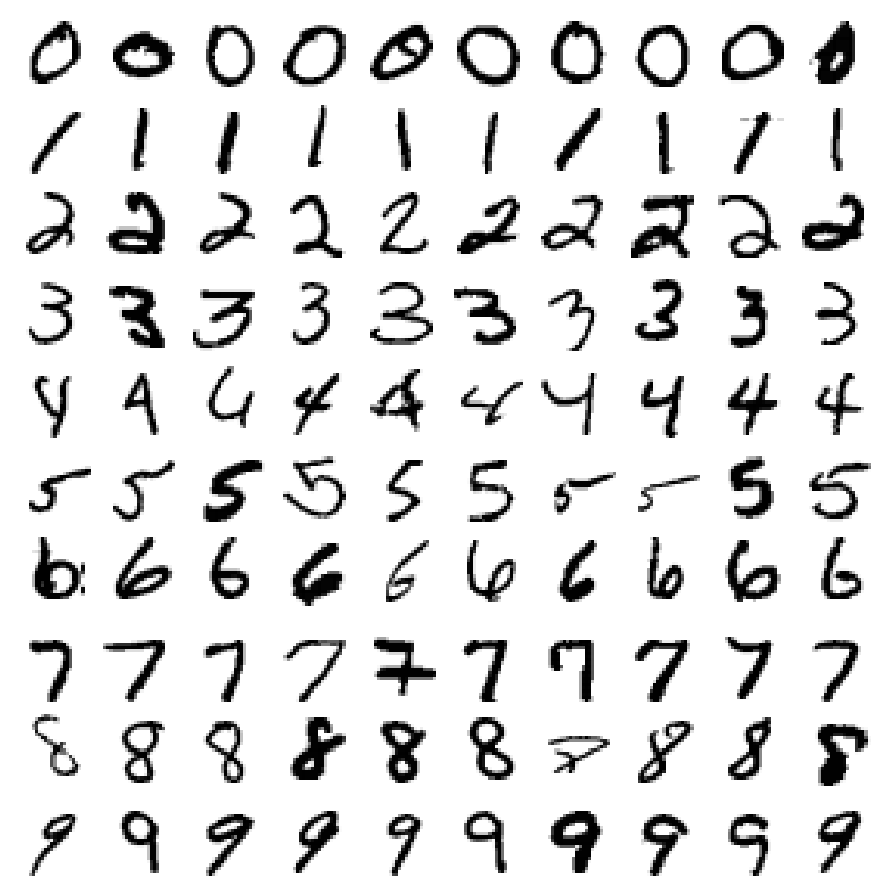

In [13]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

Let's split up our dataset into training and test data

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Shuffle so that our SGD Classifier performs better

In [15]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

First, we're going to build a binary classifier that determines whether an image is a 5 or not. Let's set up our labels:

In [16]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Fit the model!

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

That wasn't so hard.  Let's see how it performs:

In [21]:
sgd_clf.predict([some_digit])

array([ True])

It's correct! Now let's create some metrics to measure how well the model performs.  First, we'll use a simple cross validation function from Scikit:

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9613, 0.9635, 0.9661])

Not too bad! But what if we want to get fancy with it? Let's manually set up that cross validation function so that we can have more control over the process. 

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96815
0.92615
0.96185


Talk about outstanding results! But let's not get too far ahead of ourselves.  Look at the score for this BaseEstimator that just puts everything in the not-5 class. 

In [24]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [25]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

90%! This is because only about 10% of the images are 5s.  If you guess that none of them are 5, then you'll still be right 90% of the time.  This is why accuracy is not the preferred metric for binary classification.  

Let's try measuring our performance again, but this time with some more suitable metrics- let's compute a confusion matrix.  To do this, we have to create a set of predictions to compare against our actual targets. For integrity's sake, we'll leave the test set untouched and make our set of predictions on the training set using Scikit's cross_val_predict:

In [27]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Let's make our confusion matrix:

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54122,   457],
       [ 1725,  3696]])

Based off of this confusion matrix and using some handy dandy tools provided to us by Scikit, we can compute our recall and precision scores:

In [31]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8899590657356128

In [30]:
recall_score(y_train_5, y_train_pred)

0.6817930271167681

Ok, but how about we combine these into an F1 score: 

In [32]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7720910800083559

Let's dig into how we can adjust our recall and precision by messing with our threshold:

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([5220.50278623])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [37]:
y_some_digit_pred

array([ True])

In [38]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

So now we know that increasing our threshold decreases our recall.  So how do we decide what threshold to use? Well, first we need the scores of all instances in the training set using cross_val_predict:

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [42]:
y_scores.shape

(60000,)

In [43]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

Then, we can plot precision and recall as functions of the threshold:

In [44]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


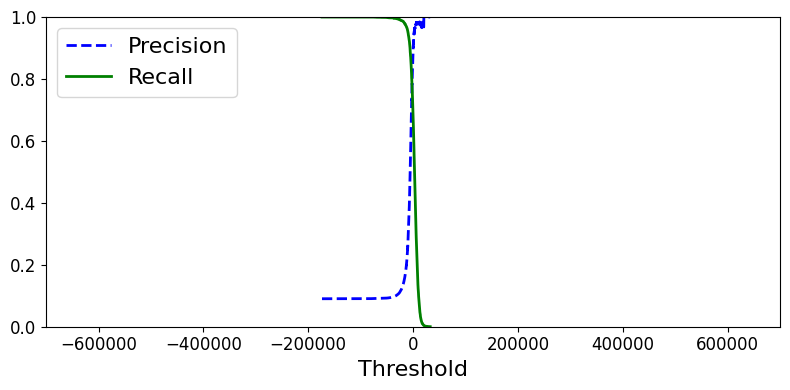

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


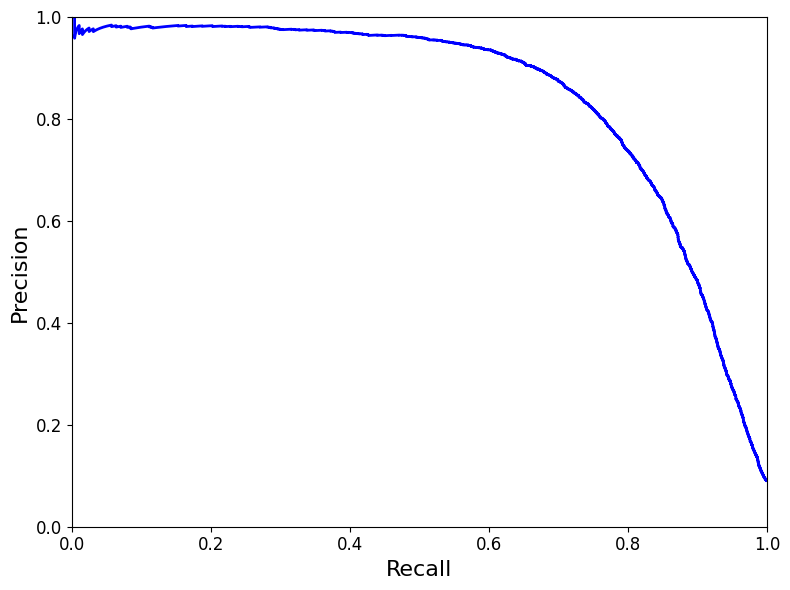

In [46]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Using this, we can determine what threshold we need to achieve a high precision.  But we want a high recall too! 

Let's build a ROC curve by computing the TPR and FPR for various threshold values using the roc_curve() function:

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


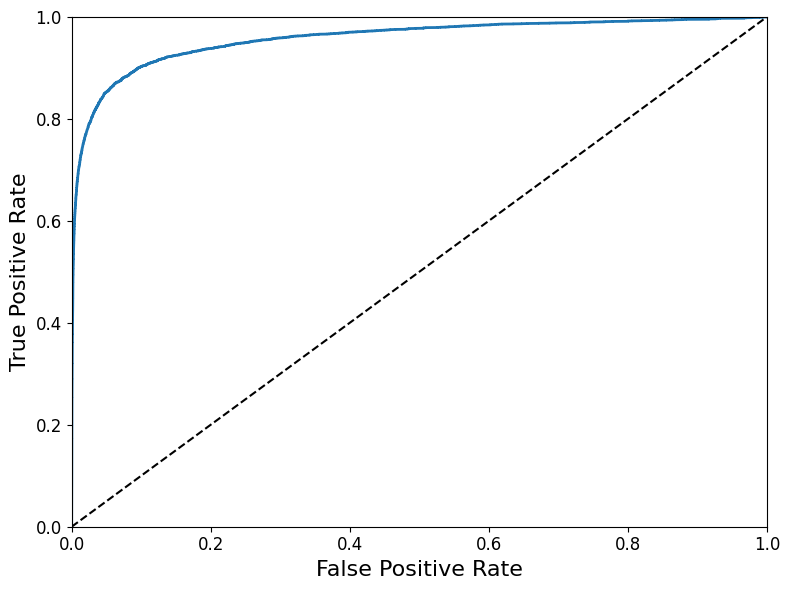

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

Here we can clearly see a tradeoff- the higher the recall (TPR), the more false positives we produce. Let's compute the area under the curve:

In [49]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9577210519742373

That's pretty close to 1- not too shabby!

Now, let's train a Random Forest Classifier and compare it's ROC curve and AUC to our SGD classifier:

In [50]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [51]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


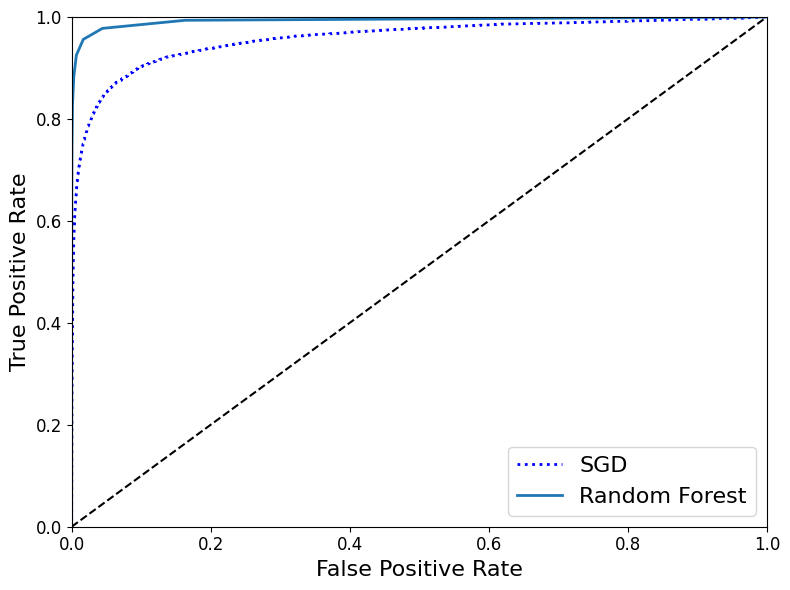

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [53]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

As we can see, the Random Forest classifier appears to fit much better than the SGD, as we can see that ROC curve far in the upper lefthand corner and an AUC very close to 1.

Now, we'll move on to multiclass classification.  If we try to fit a binary classification algorithm for a multiclass classification task, Scikit automatically runs a One vs All strategy:

In [54]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

Let's test it out!

In [55]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -8204.47519778, -19206.28224706,  -5702.10113982,
         -4666.3653033 , -15827.7809826 ,   1782.52380291,
        -39807.3747045 , -18945.8333413 , -14650.34384565,
        -16166.06981109]])

Here we can see that our decision function returns 10 scores- one for each digit. We can also see that the score for 5 is the highest. Yay!

But what if we want to use a One Vs One?

In [57]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

Alright, but now let's try a Random Forest Classifier:

In [58]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [59]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

As we can see, our classifier is pretty confident that our digit is a 5.  Now, let's evaluate our SGD classifier using cross_val_score:

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88875, 0.8722 , 0.87905])

Over 84% on all test folds- we can do better.  Let's improve this score by scaling our inputs:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

Let's try out a simple multi label classification system.


In [63]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Here we create our multilabel array- one bucket for large digits (7, 8, 9), and one bucket for odd digits. Then we train a K Neighbors Classifier- let's see how it does:

In [64]:
knn_clf.predict([some_digit])

array([[False,  True]])

Not too shabby.

In [65]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525